In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display, display_markdown

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import subprocess as sp
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import pymc3 as pm
import arviz as az
import bambi
import copy
import random
import logging

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['figure.dpi'] = 300

from subs2vec.utensils import log_timer
from subs2vec.vecs import Vectors
from subs2vec.neighbors import compute_nn

def display_md(md, **kwargs):
    return display_markdown(md, raw=True, **kwargs)

def convert_notebook(title, output='html'):
    convert = sp.run(f'jupyter nbconvert {title}.ipynb --to {output} --output {title}.{output}'.split(' '))
    if convert.returncode == 0:
        display_md(f'Jupyter notebook `{title}` converted successfully.')
    else:
        display_md(f'Error: encountered problem converting Jupyter notebook `{title}`')

def norm(x):
    return x / np.linalg.norm(x, 2)

sns.set(style='whitegrid')
pd.options.mode.chained_assignment = None

# Loading and preparing data

In [2]:
df_joint = pd.read_csv('data/data_plus_predictors.tsv', sep='\t', low_memory=False)
display(df_joint)

,index,group,dimension,pp_id,color,rating,experiment,self_vs_other,art,fiction,...,sighted,group_eff,group_z,original,replication_1,replication_2,other,self,self_vs_other_eff,self_vs_other_z
0,0,sighted,cold-hot,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
1,1,sighted,ripe-unripe,sighted_1,white,7,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
2,2,sighted,new-old,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
3,3,sighted,submissive-aggressive,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
4,4,sighted,selfless-jealous,sighted_1,white,1,original,self,NaN,NaN,...,1,1.0,0.211241,1,0,0,0,1,-1.0,-0.891882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42975,28507,sighted,light-heavy,sighted_68129,red,5,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199
42976,28508,sighted,relaxed-tense,sighted_68129,red,5,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199
42977,28509,sighted,alive-dead,sighted_68129,red,6,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199
42978,28510,sighted,fast-slow,sighted_68129,red,3,replication_2,other,11.0,0.0,...,1,1.0,0.211241,0,0,1,1,0,1.0,1.121199


# Intraclass correlations

In [3]:
# create item-level variable
df_joint['item'] = df_joint.apply(lambda x: x['color'] + '_' + x['dimension'], axis=1)

## Original study, blind group intraclass correlation

In [4]:
pg.intraclass_corr(df_joint[(df_joint['experiment'] == 'original') & (df_joint['group'] == 'blind')],
                   targets='item', raters='pp_id', ratings='rating').round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.35,7.47,152,1683,0.0,"[0.29, 0.42]"
1,ICC2,Single random raters,0.35,8.16,152,1672,0.0,"[0.29, 0.42]"
2,ICC3,Single fixed raters,0.37,8.16,152,1672,0.0,"[0.32, 0.44]"
3,ICC1k,Average raters absolute,0.87,7.47,152,1683,0.0,"[0.83, 0.9]"
4,ICC2k,Average random raters,0.87,8.16,152,1672,0.0,"[0.83, 0.9]"
5,ICC3k,Average fixed raters,0.88,8.16,152,1672,0.0,"[0.85, 0.9]"


## Original study, sighted group intraclass correlation

In [5]:
pg.intraclass_corr(df_joint[(df_joint['experiment'] == 'original') & (df_joint['group'] == 'sighted')],
                   targets='item', raters='pp_id', ratings='rating').round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.49,20.21,152,2907,0.0,"[0.43, 0.55]"
1,ICC2,Single random raters,0.49,20.37,152,2888,0.0,"[0.43, 0.55]"
2,ICC3,Single fixed raters,0.49,20.37,152,2888,0.0,"[0.43, 0.56]"
3,ICC1k,Average raters absolute,0.95,20.21,152,2907,0.0,"[0.94, 0.96]"
4,ICC2k,Average random raters,0.95,20.37,152,2888,0.0,"[0.94, 0.96]"
5,ICC3k,Average fixed raters,0.95,20.37,152,2888,0.0,"[0.94, 0.96]"


## 2nd Replication study, intraclass correlation (all sighted participants)

In [6]:
df_rep = df_joint[(df_joint['experiment'] == 'replication_2') & (df_joint['self_vs_other'] == 'self')]
pg.intraclass_corr(
    df_rep,
    targets='item', raters='pp_id', ratings='rating'
).round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.27,34.14,161,14094,0.0,"[0.23, 0.32]"
1,ICC2,Single random raters,0.27,35.63,161,14007,0.0,"[0.23, 0.32]"
2,ICC3,Single fixed raters,0.28,35.63,161,14007,0.0,"[0.24, 0.33]"
3,ICC1k,Average raters absolute,0.97,34.14,161,14094,0.0,"[0.96, 0.98]"
4,ICC2k,Average random raters,0.97,35.63,161,14007,0.0,"[0.96, 0.98]"
5,ICC3k,Average fixed raters,0.97,35.63,161,14007,0.0,"[0.97, 0.98]"


The replication group does not include the 1st replication round (of about 30 participants) because the data for those participants were unbalanced and this ICC algorithm does not play nice with unbalanced data. No matter though, there are about 100 participants in the 2nd round of the replication study, which is enough for estimating the ICC.

Overall, it appears that:
1. ICC between participants was lower in the blind group (.35) than in the sighted group (.49) in the original experiment, but both groups had higher between participants ICC than (sighted) replication group (.28). This doesn't really tell us anything about blind versus sighted participants.
2. ICC to the mean was lower in the blind group than in both the sighted groups (original and replication) but since we know that means are more stable in larger groups, it follows that we cannot directly compare groups of different sample sizes.

To address the second point, we can repeatedly draw a smaller sample from the complete sighted dataset to see if this yields ICCs more similar to the ICCs for the blind participants.

In [7]:
# draw random samples from the replication dataset
iccs = []
for i in range(100):
    random_pps = random.sample(list(df_rep['pp_id']), 12)
    iccs.append(
        pg.intraclass_corr(
            df_rep[df_rep['pp_id'].isin(random_pps)],
            targets='item', raters='pp_id', ratings='rating'
        ).round(2)
    )
pd.concat(iccs).groupby(['Type', 'Description']).mean().reset_index().sort_values('Description',
                                                                                  ascending=False).round(2)

,Type,Description,ICC,F,df1,df2,pval
0,ICC1,Single raters absolute,0.28,5.46,161.0,1662.12,0.0
2,ICC2,Single random raters,0.28,5.65,161.0,1651.86,0.0
4,ICC3,Single fixed raters,0.29,5.65,161.0,1651.86,0.0
1,ICC1k,Average raters absolute,0.80,5.46,161.0,1662.12,0.0
3,ICC2k,Average random raters,0.80,5.65,161.0,1651.86,0.0
5,ICC3k,Average fixed raters,0.81,5.65,161.0,1651.86,0.0


If we draw a random sample from the replication data with the same number of participants as the blind participants in the original data, we get pretty similar ICC-to-means as in the blind group. This means that a) the variability in the blind group doesn't seem to be out of the ordinary, and b) given the need to resort to subsampling, ICC is perhaps not the ideal tool for examining differences between these groups.

## ICC in low versus high reading groups
One last thing we can check is whether participants that read a lot are more similar to each other (more semantically aligned) than participants that do not read very much.

In [8]:
df_rep['art_high'] = df_rep['art'] >= df_rep['art'].median()
df_rep['reading_motivation_high'] = df_rep['reading_motivation'] >= df_rep['reading_motivation'].median()

### Median split based on ART

In [9]:
# low ART group
pg.intraclass_corr(
    df_rep[df_rep['art_high'] == False],
    targets='item', raters='pp_id', ratings='rating'
).round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.23,14.46,161,6966,0.0,"[0.2, 0.28]"
1,ICC2,Single random raters,0.23,15.28,161,6923,0.0,"[0.2, 0.28]"
2,ICC3,Single fixed raters,0.24,15.28,161,6923,0.0,"[0.21, 0.29]"
3,ICC1k,Average raters absolute,0.93,14.46,161,6966,0.0,"[0.91, 0.95]"
4,ICC2k,Average random raters,0.93,15.28,161,6923,0.0,"[0.91, 0.95]"
5,ICC3k,Average fixed raters,0.93,15.28,161,6923,0.0,"[0.92, 0.95]"


In [10]:
# high ART group
pg.intraclass_corr(
    df_rep[df_rep['art_high'] == True],
    targets='item', raters='pp_id', ratings='rating'
).round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.32,21.45,161,6966,0.0,"[0.27, 0.37]"
1,ICC2,Single random raters,0.32,22.11,161,6923,0.0,"[0.27, 0.37]"
2,ICC3,Single fixed raters,0.32,22.11,161,6923,0.0,"[0.28, 0.38]"
3,ICC1k,Average raters absolute,0.95,21.45,161,6966,0.0,"[0.94, 0.96]"
4,ICC2k,Average random raters,0.95,22.11,161,6923,0.0,"[0.94, 0.96]"
5,ICC3k,Average fixed raters,0.95,22.11,161,6923,0.0,"[0.94, 0.96]"


## Median split based on reading motivation score

In [11]:
# low reading group
display(pg.intraclass_corr(
    df_rep[df_rep['reading_motivation_high'] == False],
    targets='item', raters='pp_id', ratings='rating'
).round(2))

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.29,19.52,161,7128,0.0,"[0.25, 0.34]"
1,ICC2,Single random raters,0.29,20.29,161,7084,0.0,"[0.25, 0.35]"
2,ICC3,Single fixed raters,0.30,20.29,161,7084,0.0,"[0.26, 0.35]"
3,ICC1k,Average raters absolute,0.95,19.52,161,7128,0.0,"[0.94, 0.96]"
4,ICC2k,Average random raters,0.95,20.29,161,7084,0.0,"[0.94, 0.96]"
5,ICC3k,Average fixed raters,0.95,20.29,161,7084,0.0,"[0.94, 0.96]"


In [12]:
# high reading group
pg.intraclass_corr(
    df_rep[df_rep['reading_motivation_high'] == True],
    targets='item', raters='pp_id', ratings='rating'
).round(2)

,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.25,15.50,161,6804,0.0,"[0.21, 0.3]"
1,ICC2,Single random raters,0.25,16.22,161,6762,0.0,"[0.21, 0.3]"
2,ICC3,Single fixed raters,0.26,16.22,161,6762,0.0,"[0.22, 0.31]"
3,ICC1k,Average raters absolute,0.94,15.50,161,6804,0.0,"[0.92, 0.95]"
4,ICC2k,Average random raters,0.94,16.22,161,6762,0.0,"[0.92, 0.95]"
5,ICC3k,Average fixed raters,0.94,16.22,161,6762,0.0,"[0.92, 0.95]"


Overall, the differences between the groups are quite small, so we should be careful not to overinterpret them. On top of that, the direction of the differences is not the same for our two reading measures (ART and composite reading score) so there really doesn't seem to be anything here.

# Interaction between reading and predictiveness of COCA-fiction semantic projections
In addition to asking whether reading more makes participants more similar to each other, we can also ask whether reading more makes participants more similar to a semantic projection model based on word embeddings.  
We look at interactions between the COCA-fiction cosine measure, and various reading-related measures gathered from the participants in our replication study.

In [13]:
m_all = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*art_z'
    + ' + cosine_fic_z*fiction_z'
    + ' + cosine_fic_z*nonfiction_z'
    + ' + cosine_fic_z*reading_motivation_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*art_z + cosine_fic_z*fiction_z + cosine_fic_z*nonfiction_z + cosine_fic_z*reading_motivation_z + swow_all_z|pp_id)'
    + ' + (1 + cosine_fic_z|dimension)'
    + ' + (1 + cosine_fic_z|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna(),
)
r_all = m_all.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

[INFO] Lock 11561824752 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11561824752 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 46,701
[INFO] Finished [100%]: Average Loss = 46,701
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, art_z, cosine_fic_z:art_z, fiction_z, cosine_fic_z:fiction_z, nonfiction_z, cosine_fic_z:nonfiction_z, reading_motivation_z, cosine_fic_z:reading_motivation_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, art_z|pp_id_sigma, art_z|pp_id_offset, cosine_fic_z:art_z|pp_id_sigma, cosine_fic_z:art_z|pp_id_offset, fiction_z|pp_id_sigma, fiction_z|pp_id_offset, cosine_fic_z:fiction_z|pp_id_sigma, cosine_fic_z:fiction_z|pp_id_offset, nonfiction_z|pp_id_sigma, nonfiction_z|pp_id_offset, cosine_fic_z:nonfiction_z|pp_id_sigma, cosine_fic_z:nonfiction_z|pp_id_offset, reading_motivation_z|pp_id_sigma, reading

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4806 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4806 seconds.


In [14]:
varnames = [
    'cosine_fic_z',
    'art_z',
    'fiction_z',
    'nonfiction_z',
    'reading_motivation_z',
    'cosine_fic_z:art_z',
    'cosine_fic_z:fiction_z',
    'cosine_fic_z:nonfiction_z',
    'cosine_fic_z:reading_motivation_z',
]
trace_df = az.summary(r_all, hdi_prob=.95, var_names=varnames).reset_index()
display(trace_df)

,index,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
0,cosine_fic_z,0.287,0.103,0.085,0.488,0.004,0.003,768.0,1094.0,1.0
1,art_z,0.033,0.020,-0.004,0.074,0.000,0.000,2900.0,2508.0,1.0
2,fiction_z,-0.032,0.025,-0.082,0.015,0.001,0.000,2270.0,2672.0,1.0
3,nonfiction_z,-0.004,0.022,-0.048,0.039,0.000,0.000,2772.0,2951.0,1.0
4,reading_motivation_z,-0.005,0.021,-0.047,0.036,0.000,0.000,2748.0,3080.0,1.0
5,cosine_fic_z:art_z,0.016,0.011,-0.006,0.038,0.000,0.000,3974.0,3074.0,1.0
6,cosine_fic_z:fiction_z,0.005,0.012,-0.018,0.029,0.000,0.000,4148.0,3506.0,1.0
7,cosine_fic_z:nonfiction_z,0.006,0.012,-0.018,0.030,0.000,0.000,4170.0,2875.0,1.0
8,cosine_fic_z:reading_motivation_z,-0.010,0.011,-0.032,0.011,0.000,0.000,4853.0,3308.0,1.0


/opt/homebrew/lib/python3.9/site-packages/seaborn/categorical.py:1679: UserWarning: You passed a edgecolor/edgecolors ([(0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745), (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


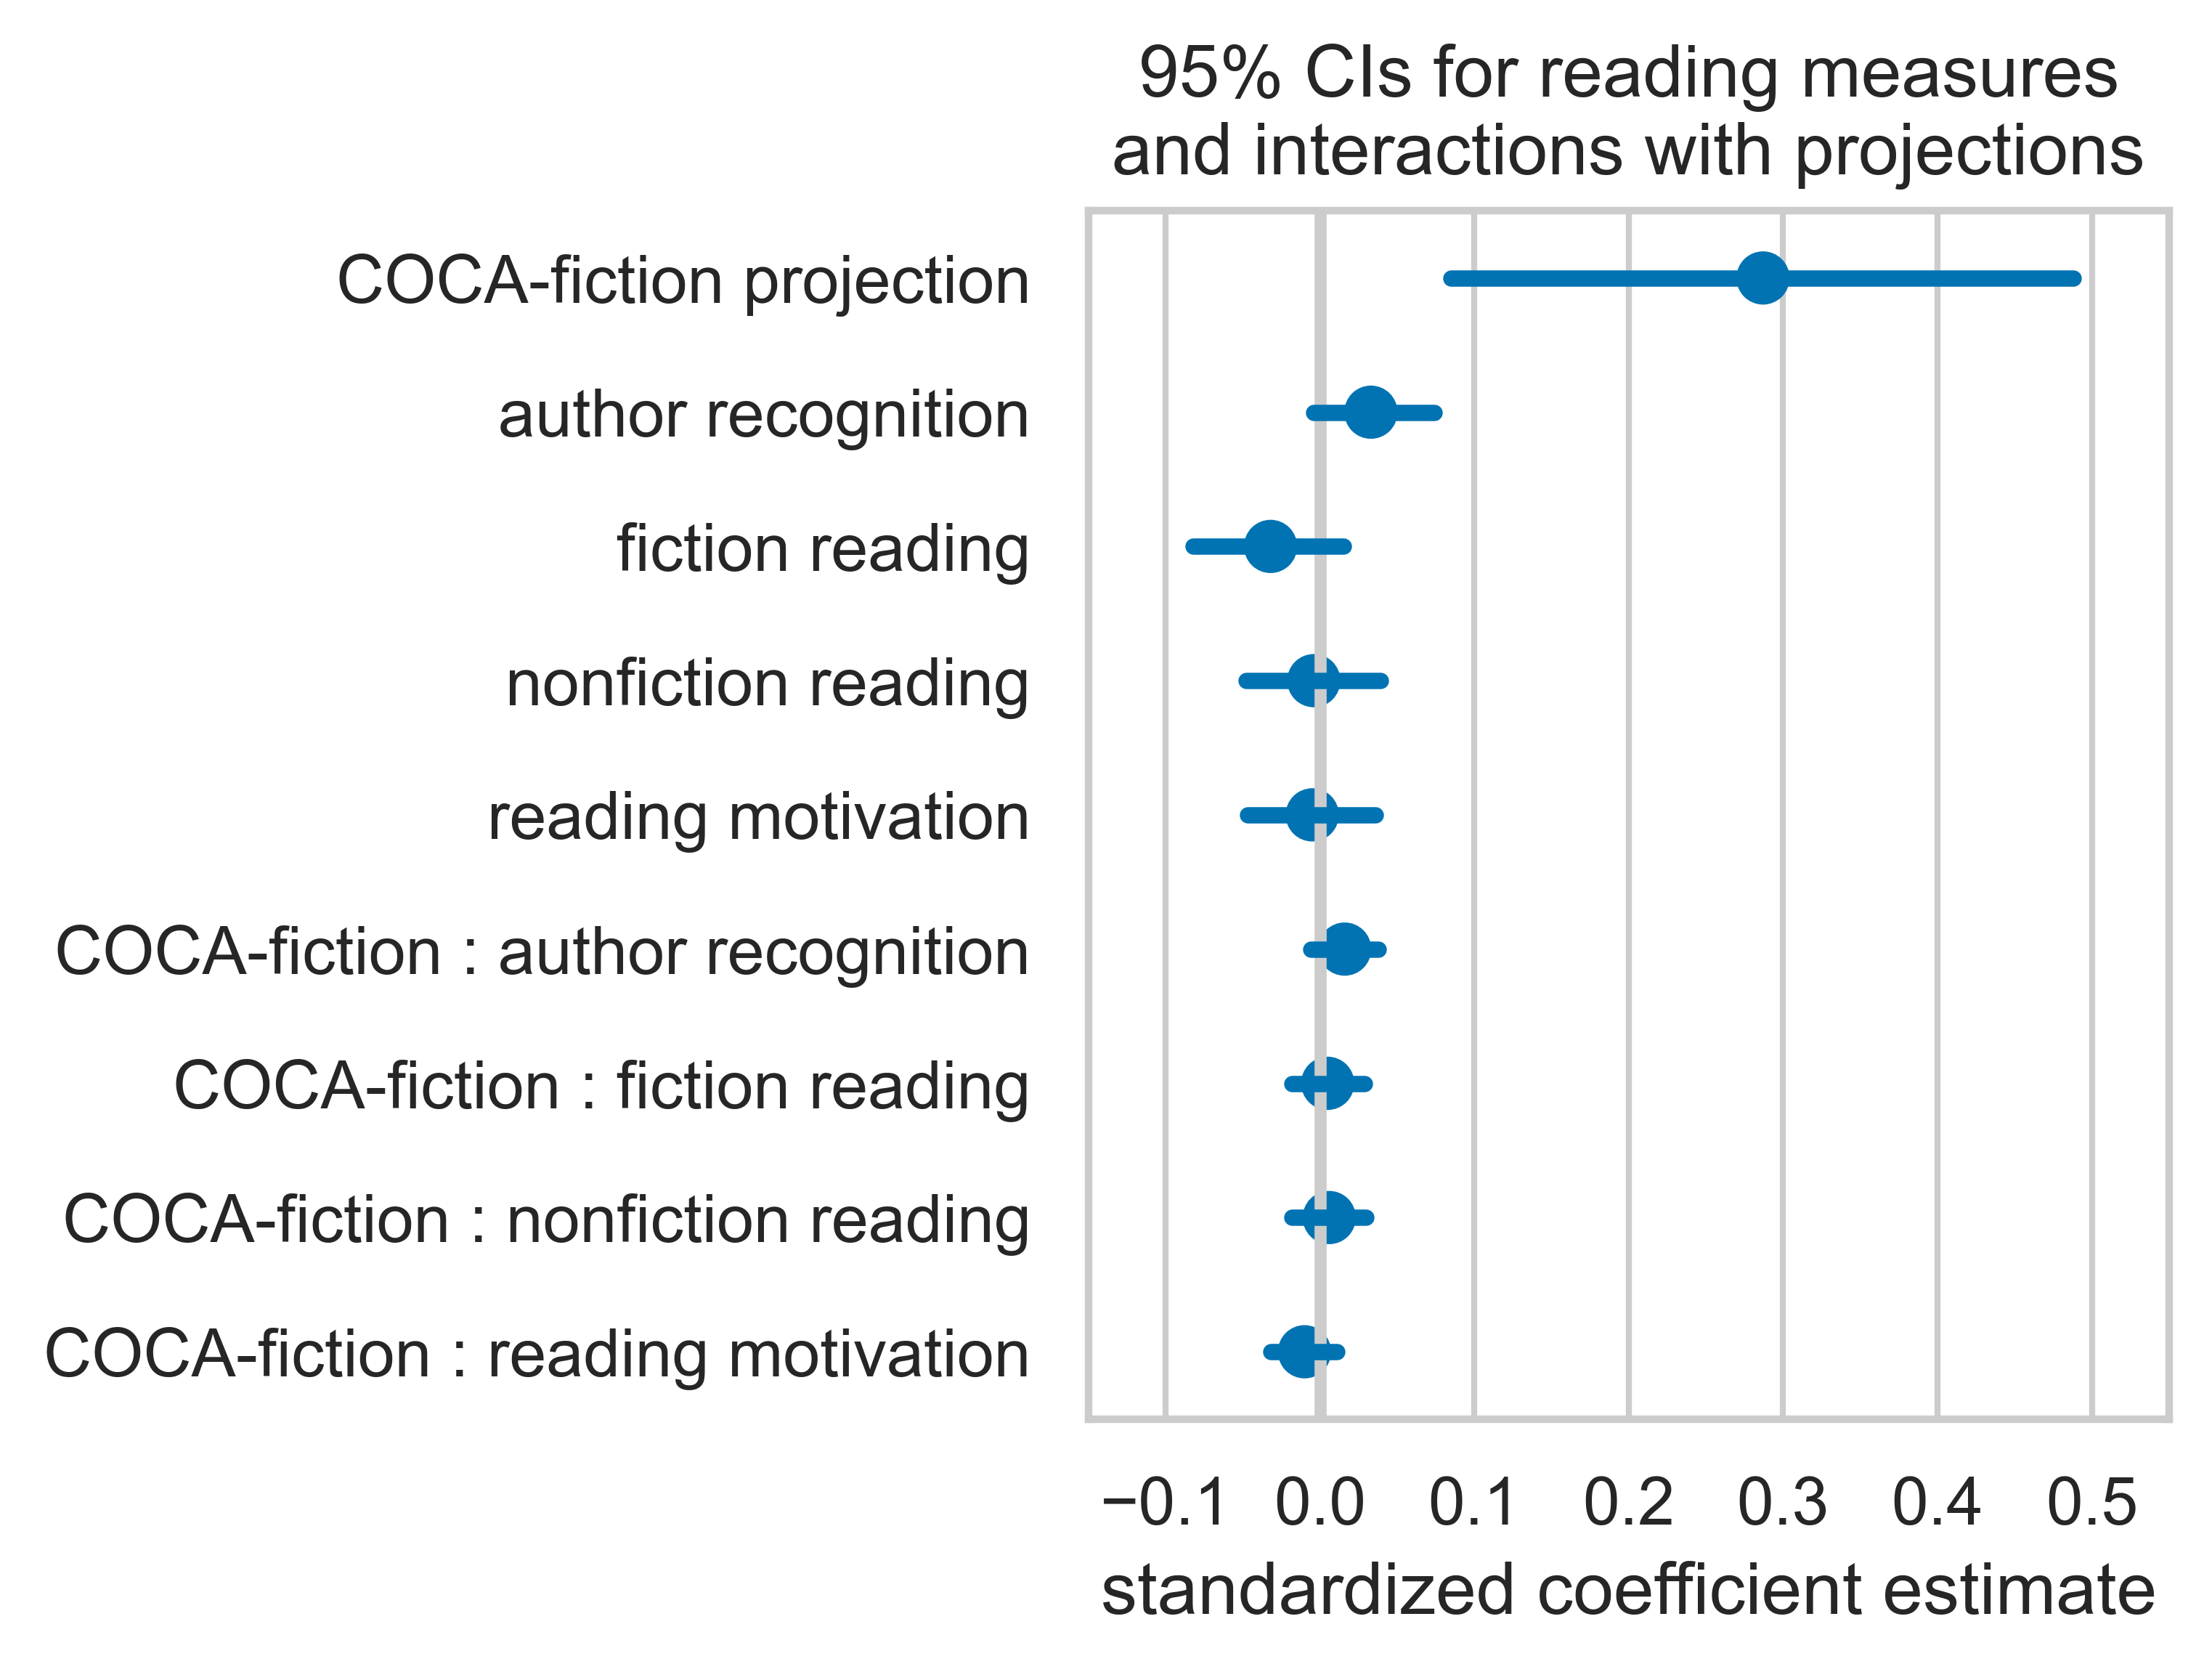

In [15]:
sns.set(palette='colorblind', style='whitegrid')
g, ax = plt.subplots(figsize=[3.2, 3.6])
ax.axvline(0, color='.8', linewidth=2)
sns.pointplot(data=trace_df, x='mean', y='index', join=False, ax=ax,
              color=sns.color_palette()[0])
hdi_df = trace_df.melt(id_vars=['index'], value_vars=['hdi_2.5%', 'hdi_97.5%'])
sns.pointplot(data=hdi_df, markers='', x='value', color=sns.color_palette()[0],
              y='index', ax=ax, join=False)
ax.set(xlim=[-.15, .55], ylabel='', xlabel='standardized coefficient estimate', xticks=[-.1, 0, .1, .2, .3, .4, .5],
       title='95% CIs for reading measures\nand interactions with projections')
ax.set(yticklabels=[
    'COCA-fiction projection',
    'author recognition',
    'fiction reading',
    'nonfiction reading',
    'reading motivation',
    'COCA-fiction : author recognition',
    'COCA-fiction : fiction reading',
    'COCA-fiction : nonfiction reading',
    'COCA-fiction : reading motivation'
])
plt.savefig('figures/reading_measures_forest.pdf', bbox_inches='tight')

In [16]:
display(az.summary(r_all, var_names=varnames, hdi_prob=.95))

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cosine_fic_z,0.287,0.103,0.085,0.488,0.004,0.003,768.0,1094.0,1.0
art_z,0.033,0.020,-0.004,0.074,0.000,0.000,2900.0,2508.0,1.0
fiction_z,-0.032,0.025,-0.082,0.015,0.001,0.000,2270.0,2672.0,1.0
nonfiction_z,-0.004,0.022,-0.048,0.039,0.000,0.000,2772.0,2951.0,1.0
reading_motivation_z,-0.005,0.021,-0.047,0.036,0.000,0.000,2748.0,3080.0,1.0
cosine_fic_z:art_z,0.016,0.011,-0.006,0.038,0.000,0.000,3974.0,3074.0,1.0
cosine_fic_z:fiction_z,0.005,0.012,-0.018,0.029,0.000,0.000,4148.0,3506.0,1.0
cosine_fic_z:nonfiction_z,0.006,0.012,-0.018,0.030,0.000,0.000,4170.0,2875.0,1.0
cosine_fic_z:reading_motivation_z,-0.010,0.011,-0.032,0.011,0.000,0.000,4853.0,3308.0,1.0


## Reading subscales
### Reading motivation

In [17]:
m_comp = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*reading_motivation_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*reading_motivation_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_comp = m_comp.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 41,011
[INFO] Finished [100%]: Average Loss = 41,011
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_motivation_z, cosine_fic_z:reading_motivation_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, reading_motivation_z|pp_id_sigma, reading_motivation_z|pp_id_offset, cosine_fic_z:reading_motivation_z|pp_id_sigma, cosine_fic_z:reading_motivation_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, 1|color_sigma, 1|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_motivation_z, cosine_fic_z:reading_motivation_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequenc

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2985 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2985 seconds.


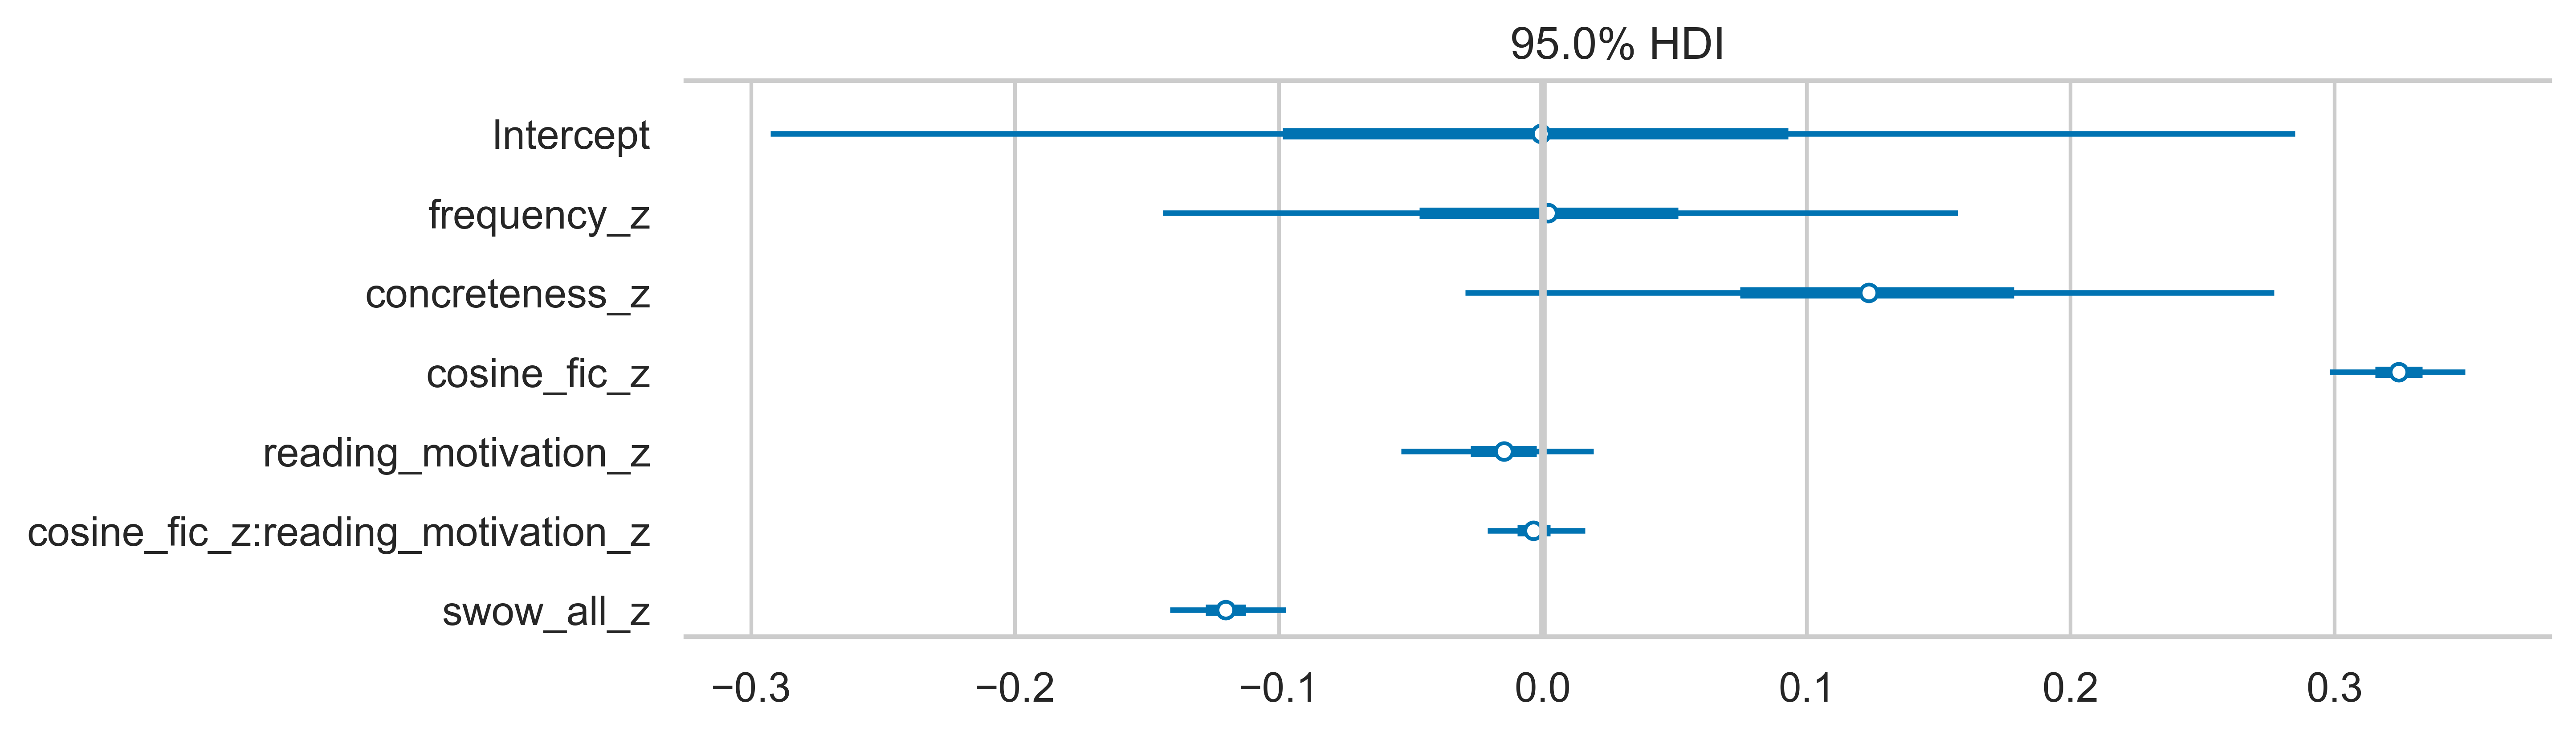

In [18]:
varnames = [
    'Intercept',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'reading_motivation_z',
    'cosine_fic_z:reading_motivation_z',
    'swow_all_z',
]
g = az.plot_forest(r_comp, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

### Reading as part of self

In [19]:
m_self = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*reading_part_of_self_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*reading_part_of_self_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_self = m_self.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 41,078
[INFO] Finished [100%]: Average Loss = 41,078
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_part_of_self_z, cosine_fic_z:reading_part_of_self_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, reading_part_of_self_z|pp_id_sigma, reading_part_of_self_z|pp_id_offset, cosine_fic_z:reading_part_of_self_z|pp_id_sigma, cosine_fic_z:reading_part_of_self_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, 1|color_sigma, 1|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_part_of_self_z, cosine_fic_z:reading_part_of_self_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1534 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1534 seconds.


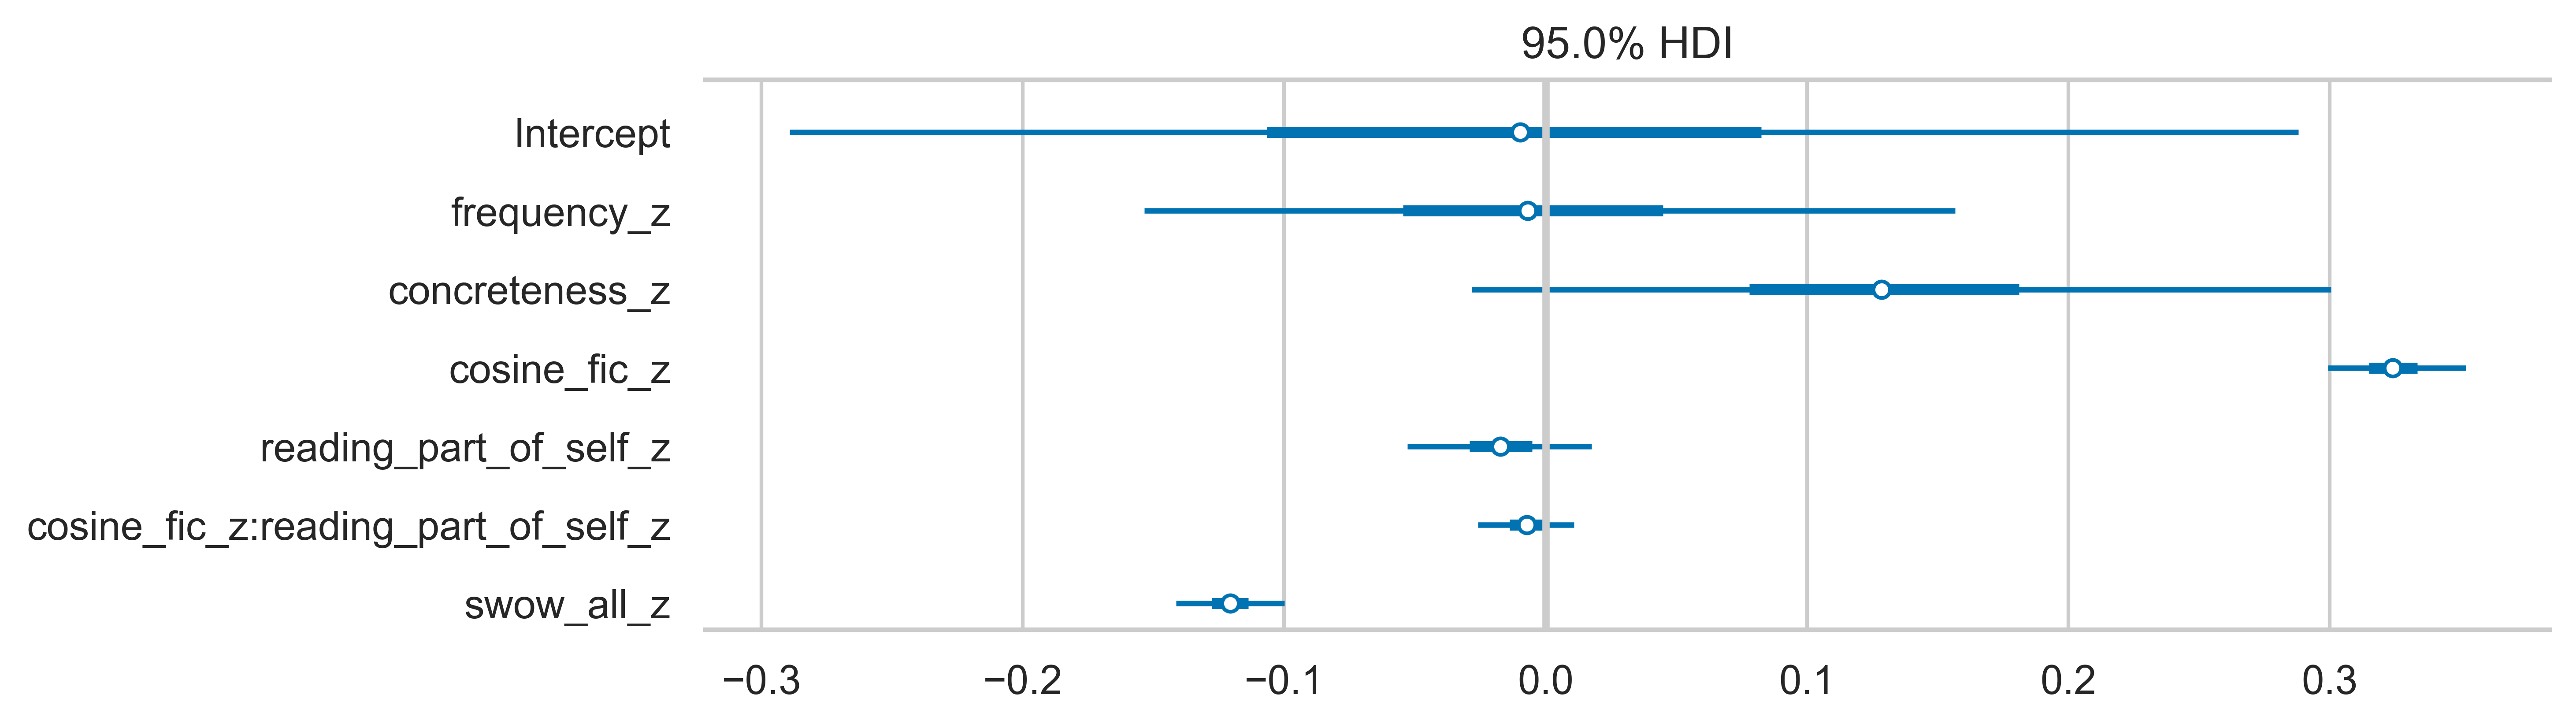

In [20]:
varnames = [
    'Intercept',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'reading_part_of_self_z',
    'cosine_fic_z:reading_part_of_self_z',
    'swow_all_z',
]
g = az.plot_forest(r_self, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

### Reading efficacy

In [21]:
m_eff = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*reading_efficacy_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*reading_efficacy_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_eff = m_eff.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

Auto-assigning NUTS sampler...
[INFO] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
[INFO] Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 41,109
[INFO] Finished [100%]: Average Loss = 41,109
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_efficacy_z, cosine_fic_z:reading_efficacy_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, reading_efficacy_z|pp_id_sigma, reading_efficacy_z|pp_id_offset, cosine_fic_z:reading_efficacy_z|pp_id_sigma, cosine_fic_z:reading_efficacy_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, 1|color_sigma, 1|color_offset, rating_z_sigma]
[INFO] NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_efficacy_z, cosine_fic_z:reading_efficacy_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1725 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1725 seconds.


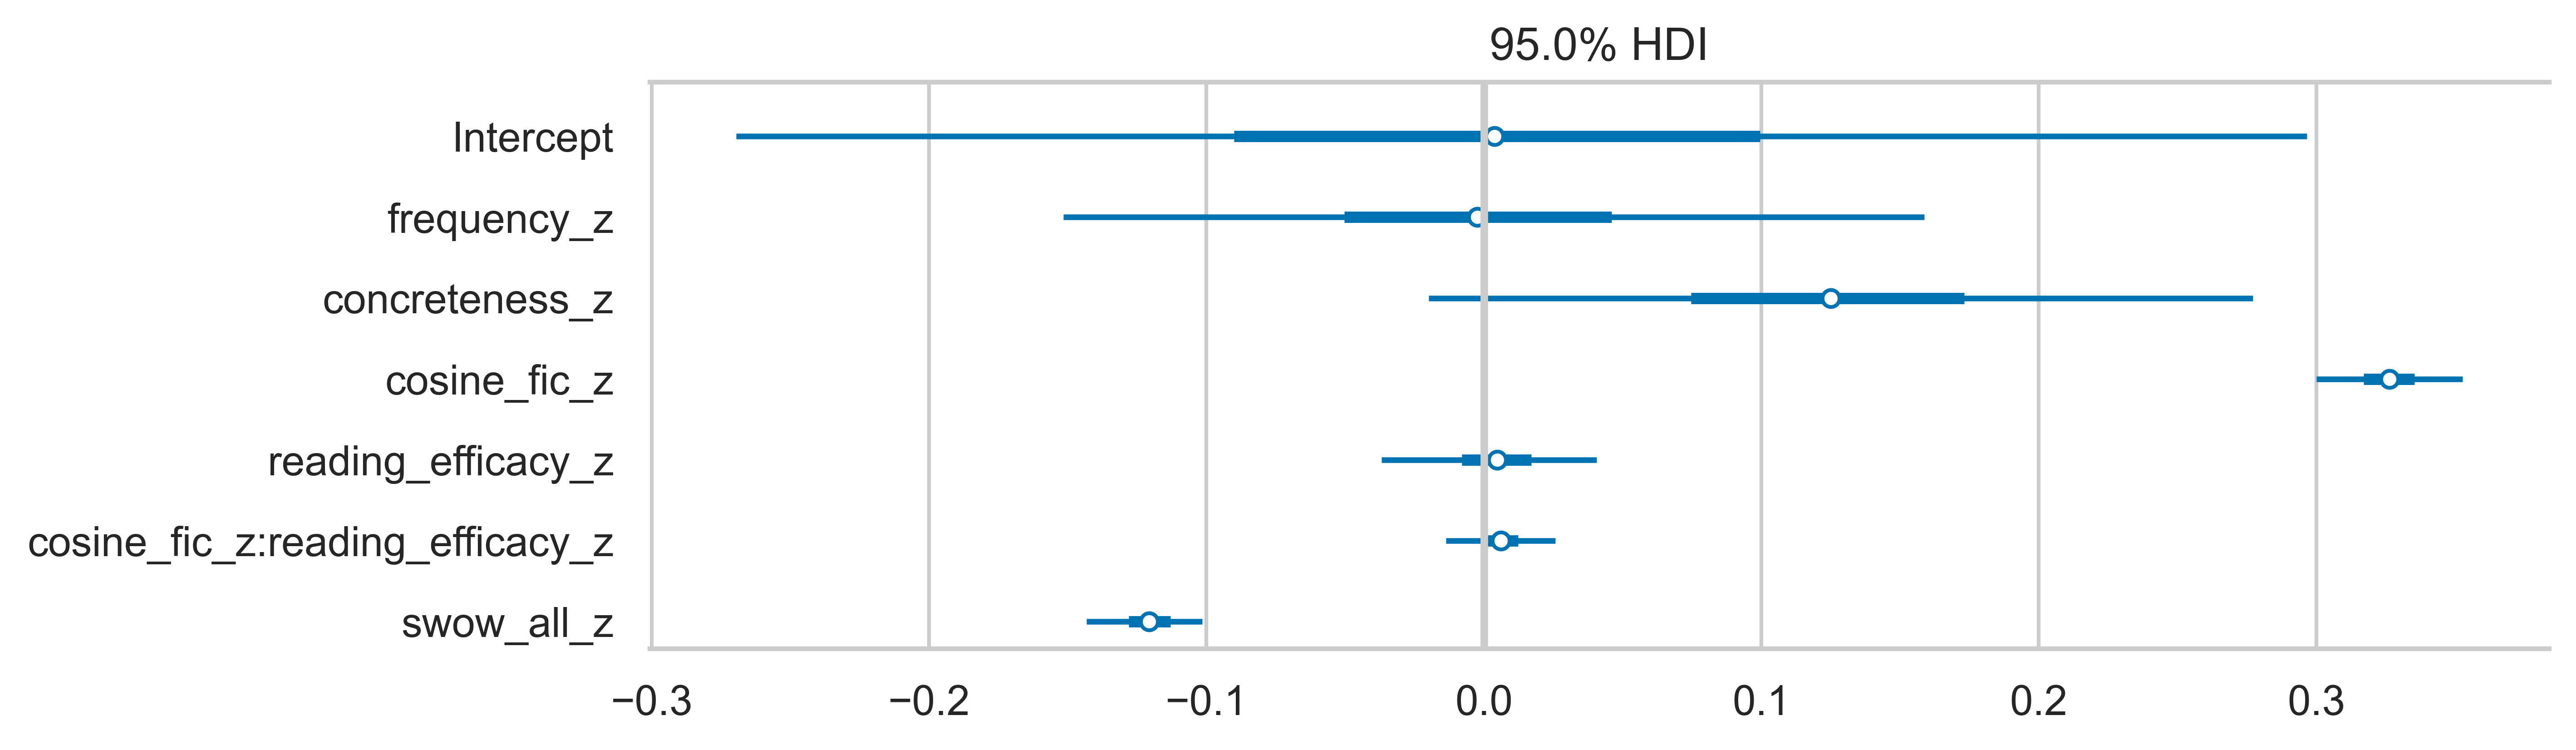

In [22]:
varnames = [
    'Intercept',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'reading_efficacy_z',
    'cosine_fic_z:reading_efficacy_z',
    'swow_all_z',
]
g = az.plot_forest(r_eff, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

### Reading for recognition

In [23]:
m_recog = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*reading_recognition_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*reading_recognition_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_recog = m_recog.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

[INFO] Lock 11683846032 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11683846032 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11728987664 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11728987664 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11623441600 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11623441600 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11623441840 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11623441840 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11623381456 acquired on /Users/jvpar

Finished [100%]: Average Loss = 41,127
[INFO] Finished [100%]: Average Loss = 41,127
[INFO] Lock 11605588144 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11605588144 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_recognition_z, cosine_fic_z:reading_recognition_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, reading_recognition_z|pp_id_sigma, reading_recognition_z|pp_id_offset, cosine_fic_z:reading_recognition_z|pp_id_sigma, cosine_fic_z:reading_recognition_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset, 1|co

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1676 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1676 seconds.


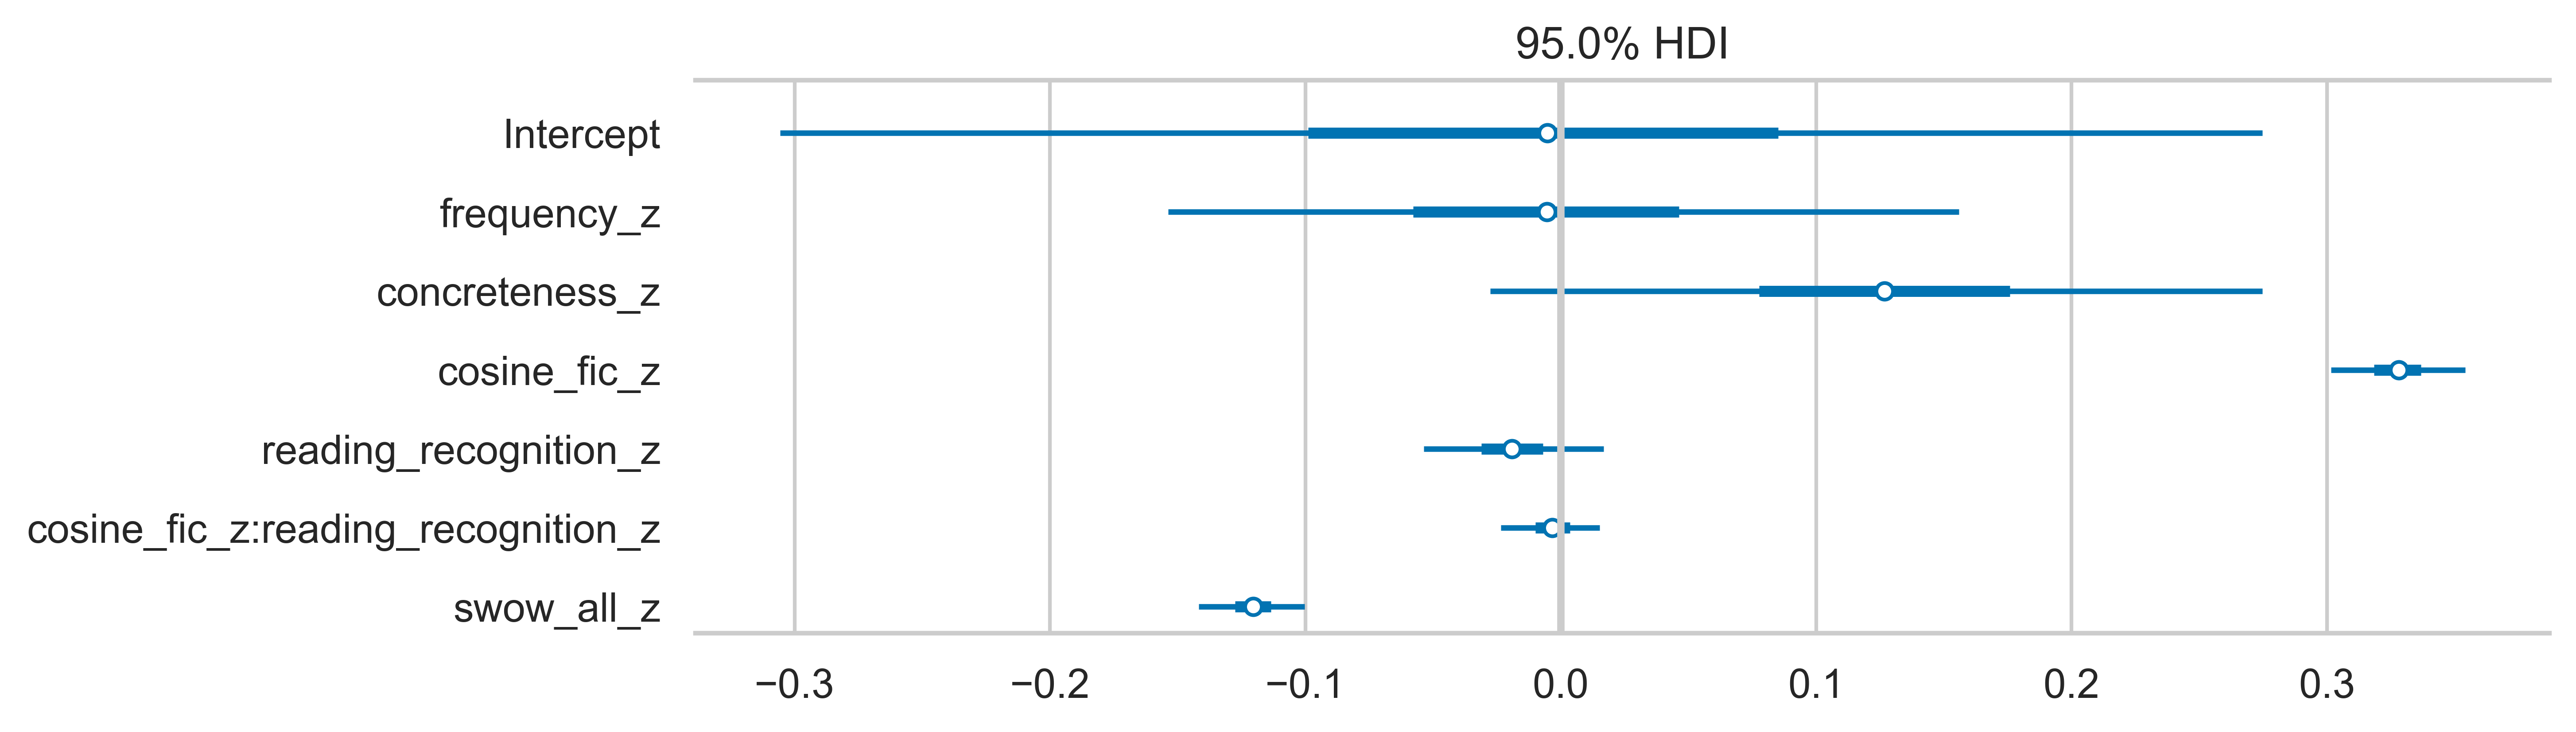

In [24]:
varnames = [
    'Intercept',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'reading_recognition_z',
    'cosine_fic_z:reading_recognition_z',
    'swow_all_z',
]
g = az.plot_forest(r_recog, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

### Reading to do well in other realms

In [25]:
m_realms = bambi.Model('rating_z ~ 1'
    + ' + frequency_z'
    + ' + concreteness_z'
    + ' + cosine_fic_z*reading_other_realms_z'
    + ' + swow_all_z'
    + ' + (1 + frequency_z + concreteness_z + cosine_fic_z*reading_other_realms_z + swow_all_z|pp_id)'
    + ' + (1|dimension)'
    + ' + (1|color)',
    df_joint[df_joint['experiment'] == 'replication_2'].dropna()
)
r_realms = m_realms.fit(
    init='advi+adapt_diag',
    n_init=10000,
    chains=4,
    draws=1000,
    tune=1000,
    target_accept=.95,
)

[INFO] Lock 11654611632 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11654611632 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11680034192 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11680034192 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11621723056 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11621723056 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11651897520 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11651897520 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11660971024 acquired on /Users/jvpar

Finished [100%]: Average Loss = 40,974
[INFO] Finished [100%]: Average Loss = 40,974
[INFO] Lock 11689025648 acquired on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
[INFO] Lock 11689025648 released on /Users/jvparidon/.aesara/compiledir_macOS-12.4-arm64-arm-64bit-arm-3.9.12-64/.lock
Multiprocess sampling (4 chains in 4 jobs)
[INFO] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, frequency_z, concreteness_z, cosine_fic_z, reading_other_realms_z, cosine_fic_z:reading_other_realms_z, swow_all_z, 1|pp_id_sigma, 1|pp_id_offset, frequency_z|pp_id_sigma, frequency_z|pp_id_offset, concreteness_z|pp_id_sigma, concreteness_z|pp_id_offset, cosine_fic_z|pp_id_sigma, cosine_fic_z|pp_id_offset, reading_other_realms_z|pp_id_sigma, reading_other_realms_z|pp_id_offset, cosine_fic_z:reading_other_realms_z|pp_id_sigma, cosine_fic_z:reading_other_realms_z|pp_id_offset, swow_all_z|pp_id_sigma, swow_all_z|pp_id_offset, 1|dimension_sigma, 1|dimension_offset

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3427 seconds.
[INFO] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3427 seconds.


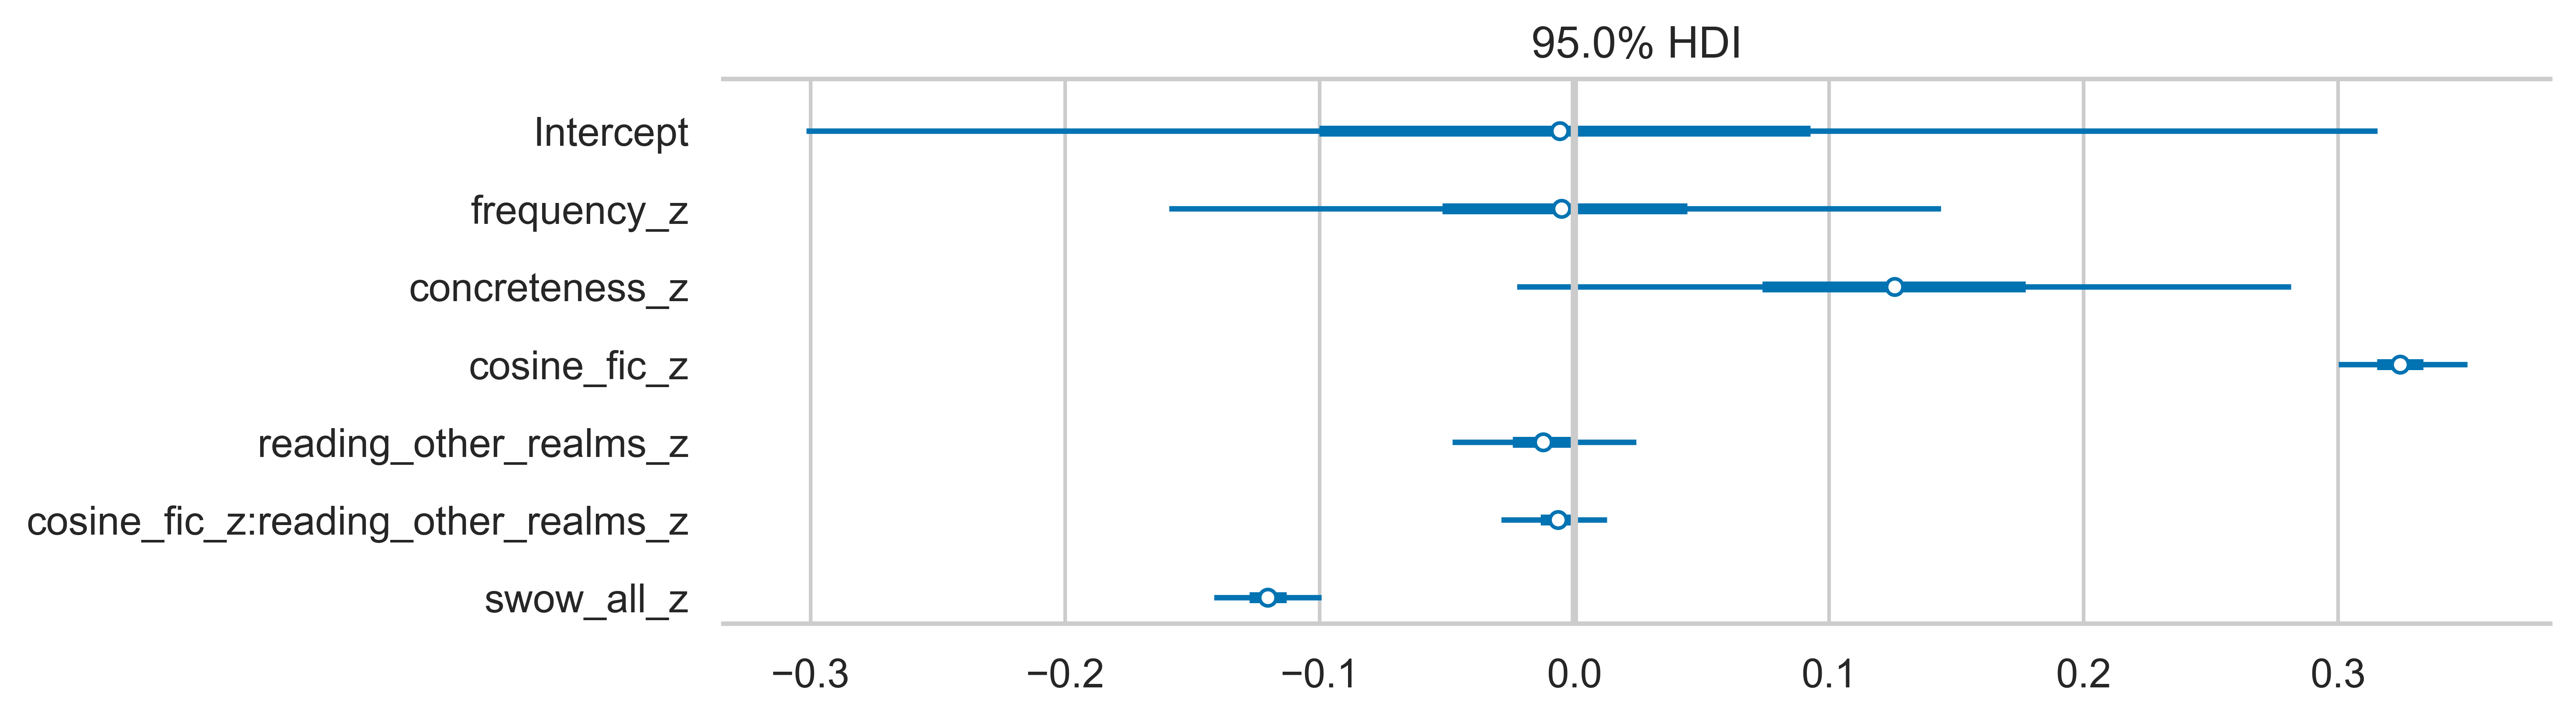

In [26]:
varnames = [
    'Intercept',
    'frequency_z',
    'concreteness_z',
    'cosine_fic_z',
    'reading_other_realms_z',
    'cosine_fic_z:reading_other_realms_z',
    'swow_all_z',
]
g = az.plot_forest(r_realms, combined=True, hdi_prob=.95,
                   figsize=[9, .6 + len(varnames) * .3],
                   var_names=varnames)
g[0].axvline(0, color='.8', linewidth=2);

None of the reading measures appear to have a meaningful effect on the ratings, nor do they interact with the semantic projection model trained on the COCA-fiction corpus.

There are (at least) two possible explanations for why these measures don't appear to have an effect:
1. Reading (and reading fiction specifically) does nothing to shape semantic knowledge (this seems unlikely, although for color associations simply experiencing the visual world certainly plays a big role as well).
2. Our participants are actually much more similar in fiction exposure than their scores suggest, because we are all exposed to a shared media environment (TV, Netflix, social media, etc.). Furthermore there is a baseline level of exposure to _written fiction_ that most undergraduate students can be expected to have (through completing K-12 education, etc.) which is sufficient for them to already be strongly semantically aligned. Further within-group differences in reading exposure then don't have much of an effect (i.e. there is some sort of ceiling effect happening).

# Convert notebook to html

In [27]:
convert_notebook('experiment_2_and_variability')

Error: encountered problem converting Jupyter notebook `experiment_2_and_variability`